# RESNET CNN and LSTM RNN
In this first model for Visual Question Answering problem, we exploited ResNet as transfer learning part for the Convolutional Neural Network, and Long Short Term Memory for Recurrent Neural Network part

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import tensorflow as tf
import numpy as np

# Set the seed for random operations, this let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Batch size
bs = 32

# img shape
img_h = 400
img_w = 700

num_classes = 58

#### Here we try to get the best partitioning of category by further attempts (explained in notebook "1_data_analysis")

In [3]:
yes_no_prefixes   = ["do","does","is","are","was","were","have","might","could","can","has","will","did","would","should","if"]
counting_prefixes = ["how"]

# Predict the category from a question

def predict_category(question):
    
    if list(filter(question.lower().startswith, yes_no_prefixes)) != []:
         return "yes_no" 
    elif list(filter(question.lower().startswith, counting_prefixes)) != [] or "number" in question.lower() or "how many" in question.lower():
        return "counting"
    
    else:
        return "other"
    
# Get the real category from the associated answer label

def real_category(label):
    
    if label in [57,33]:
        return "yes_no" 
    
    elif label in [0,1,2,3,4,5]:
        return "counting"
    
    else:
        return "other"

### Question-Answer Training Dataset
Gather questions and answers from json, and then compute predictions on category (explained in notebook "1_data_analysis")

In [4]:
from tensorflow.keras.utils import to_categorical
from os import getcwd, listdir
from os.path import join
import json

dataset_dir  = join('../input/vqa-dataset','VQA_Dataset')
training_dir = join(dataset_dir, 'Training')

labels_dict = { 
                '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'apple': 6,
                'baseball': 7, 'bench': 8, 'bike': 9, 'bird': 10, 'black': 11, 'blanket': 12, 'blue': 13,
                'bone': 14, 'book': 15, 'boy': 16, 'brown': 17, 'cat': 18, 'chair': 19, 'couch': 20,
                'dog': 21, 'floor': 22, 'food': 23, 'football': 24, 'girl': 25, 'grass': 26, 'gray': 27,
                'green': 28, 'left': 29, 'log': 30, 'man': 31, 'monkey bars': 32, 'no': 33, 'nothing': 34,
                'orange': 35, 'pie': 36, 'plant': 37, 'playing': 38, 'red': 39, 'right': 40, 'rug': 41,
                'sandbox': 42, 'sitting': 43, 'sleeping': 44, 'soccer': 45, 'squirrel': 46, 'standing': 47, 
                'stool': 48, 'sunny': 49, 'table': 50, 'tree': 51, 'watermelon': 52, 'white': 53, 'wine': 54, 
                'woman': 55, 'yellow': 56, 'yes': 57 
              }

train_dict  = {}
with open(join(dataset_dir,'train_questions_annotations.json')) as json_file:
    train_dict = json.load(json_file)

# order json by 'image_id'    
train_dict = dict(sorted(train_dict.items(), key=lambda x: int(x[1]['image_id'])))

questions, labels_answers, answers, answers_id = [], [], [], []
bad_label = 0

for line in train_dict.items():

    questions.append(line[1]["question"])
    answers.append(line[1]["answer"])
    labels_answers.append(labels_dict[line[1]["answer"]])
    
    if predict_category(line[1]["question"]) != real_category(labels_dict[line[1]["answer"]]):
        bad_label += 1

print("Number of questions badly labelled: " + str(bad_label) + " over " + str(58832))
print("In percentage: " + str(bad_label/58832*100)[:5] + " %")

# one-hot encoding for answers
for a in answers:
    answers_id.append(to_categorical(labels_dict.get(a), num_classes=58))

Number of questions badly labelled: 622 over 58832
In percentage: 1.057 %


## Tokenization
Converts question's words to integers, and retrieve maximum question length. It will be used as a parameter for question input

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_NUM_SENTENCES = 40000
MAX_NUM_WORDS = 20000

# QUESTIONS 

# Create Tokenizer to convert words to integers
questions_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)

# pass the sentences retrieved from json
questions_tokenizer.fit_on_texts(questions)

# returns a list of lists of indexes referring to words inside that sentence (max of words)
questions_tokenized = questions_tokenizer.texts_to_sequences(questions)

# returns a dict with words lowercased in alphabetical order and indexed wrt cardinality
questions_wtoi = questions_tokenizer.word_index
print('Questions:', len(questions_wtoi))

max_question_length = max(len(sentence) for sentence in questions_tokenized)
print('Max question length:', max_question_length)

Questions: 4640
Max question length: 21


'\n# Create Tokenizer to convert words to integers\nanswers_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters=\'?!,."\')\n\n### pass the sentences retrieved from txt\nanswers_tokenizer.fit_on_texts(answers)\n\n### returns a list of lists of indexes referring to words inside that sentence (max of words)\nanswers_tokenized = answers_tokenizer.texts_to_sequences(answers)\n#answers_tokenized_train = answers_tokenizer.texts_to_sequences(train_answers)\n\n### returns a dict with words lowercased in alphabetical order and indexed wrt cardinality\nanswers_wtoi = answers_tokenizer.word_index\nprint(\'Answers:\', len(answers_wtoi))\n\nmax_answer_length = max(len(sentence) for sentence in answers_tokenized)\nprint(\'Max answer length:\', max_answer_length)\n\nnum_answer_words = len(answers_wtoi) + 1'

### Padding sequences
LSTM wants batches of same length

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad (with 0) to max question length
questions_encoded = pad_sequences(questions_tokenized, maxlen=max_question_length)

print("Questions encoder inputs shape:", questions_encoded.shape)

Questions encoder inputs shape: (58832, 21)


#### Perform a 90% training/validation split

In [ ]:
filenames = [int(el[1]['image_id']) for el in train_dict.items()]   
split = int(len(filenames)*0.90)  

filenames_train = filenames[:split]
filenames_valid = filenames[split:]
len(filenames_train)
len(filenames_valid)

questions_encoded_train = questions_encoded[:split]
questions_encoded_valid = questions_encoded[split:]
len(questions_encoded_train)
len(questions_encoded_valid)

answers_train = answers_id[:split]
answers_valid = answers_id[split:]
len(answers_train)
len(answers_valid)

### Custom Dataset that returns every time a tuple like:  ( [image, question], answer ) 

In [9]:
from tensorflow.keras.applications.resnet50  import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    def __init__(self, filenames, questions, answers, preprocessing_function=preprocess_input, out_shape=[img_w,img_h],img_generator=ImageDataGenerator(rescale=1./255)):

        self.questions = questions
        self.answers = answers
        self.filenames = filenames
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self): return len(self.filenames)

    def __getitem__(self, index):

        # Read Image
        curr_filename = self.filenames[index]
        img = Image.open(join(training_dir, str(curr_filename) + '.png')).convert('RGB')

        # Resize image
        resized_img = img.resize((img_h, img_w))
        img_arr = np.array(resized_img)

        return (img_arr, self.questions[index]), self.answers[index]

In [10]:
valid_custom_dataset = CustomDataset( filenames=filenames_valid, questions=questions_encoded_valid, answers=answers_valid )
train_custom_dataset = CustomDataset( filenames=filenames_train, questions=questions_encoded_train, answers=answers_train )

#### Finally create the train and valid datasets

In [11]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_custom_dataset,
                                               output_types=((tf.uint8,tf.int32), tf.int32),
                                               output_shapes=(([img_w, img_h, 3],(max_question_length,)), (58,)) )
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.repeat()
train_dataset

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_custom_dataset,
                                               output_types=((tf.uint8,tf.int32), tf.int32),
                                               output_shapes=(([img_w, img_h, 3],(max_question_length,)), (58,)) )
valid_dataset = valid_dataset.batch(32)
valid_dataset = valid_dataset.repeat()
valid_dataset

<RepeatDataset shapes: (((None, 700, 400, 3), (None, 21)), (None, 58)), types: ((tf.uint8, tf.int32), tf.int32)>

<RepeatDataset shapes: (((None, 700, 400, 3), (None, 21)), (None, 58)), types: ((tf.uint8, tf.int32), tf.int32)>

## Model
CNN: Resnet
RNN: lsmt

In [12]:
EMBEDDING_SIZE = 16

# ENCODER

encoder_input = tf.keras.Input(shape=[max_question_length])
encoder_embedding_layer = tf.keras.layers.Embedding(len(questions_wtoi)+1, EMBEDDING_SIZE, input_length=max_question_length, mask_zero=True)
encoder_embedding_out = encoder_embedding_layer(encoder_input)
encoder = tf.keras.layers.LSTM(units=128, return_state=False)(encoder_embedding_out)

# RESNET

resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3) )
for layer in resnet.layers: 
    layer.trainable = False
resnet_flatten = tf.keras.layers.Flatten()(resnet.output) #129024 
resnet_model = tf.keras.layers.Dense(units=128)(resnet_flatten)

# Combine CNN and RNN to create the final model

merged = tf.keras.layers.Multiply()([encoder, resnet_model])
classes = len(labels_dict)  #58
output = tf.keras.layers.Dense(units=classes, activation='softmax')(merged)

#MODEL

vqa_model = tf.keras.Model(inputs=[resnet.input,encoder_input], outputs=output)

94773248/94765736 [==============================] - 1s 0us/step


"\nvgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_w, img_h, 3))\nfor layer in vgg.layers: layer.trainable = False\nvgg_flatten = tf.keras.layers.Flatten()(vgg.output) #129024 \nvgg_model = tf.keras.layers.Dense(units=128)(vgg_flatten)\n"

In [13]:
vqa_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 406, 706, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 200, 350, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 200, 350, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

#### Optimization params to compile the model

In [14]:
# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy']

# Compile Model
vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#### Fit the model and add EarlyStopping to limit overfitting 

In [15]:
callbacks = []

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
    callbacks.append(es_callback)


vqa_model.fit(x=train_dataset,
              validation_data=valid_dataset,
              epochs=100,
              steps_per_epoch=len(train_custom_dataset)/256,
              validation_steps=len(valid_custom_dataset)/256,
              batch_size=32, 
              callbacks=callbacks )

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
219/218 [==============================] - 207s 946ms/step - loss: 1.9491 - accuracy: 0.3930 - val_loss: 1.5384 - val_accuracy: 0.4193
Epoch 2/100
219/218 [==============================] - 203s 925ms/step - loss: 1.4721 - accuracy: 0.4702 - val_loss: 1.2719 - val_accuracy: 0.5677
Epoch 3/100
219/218 [==============================] - 204s 930ms/step - loss: 1.3629 - accuracy: 0.5001 - val_loss: 1.2023 - val_accuracy: 0.5078
Epoch 4/100
219/218 [==============================] - 204s 930ms/step - loss: 1.2675 - accuracy: 0.5198 - val_loss: 1.0732 - val_accuracy: 0.5703
Epoch 5/100
219/218 [==============================] - 204s 934ms/step - loss: 1.1947 - accuracy: 0.5415 - val_loss: 1.1020 - val_accuracy: 0.5911
Epoch 6/100
219/218 [==============================] - 206s 941ms/step - loss: 1.1903 - accuracy: 0.5569 - val_loss: 1.0938 - val_accuracy: 0.5885
Epoch 7/100
219/218 [==============================] - 205s 938ms/step - loss: 1.1408 - accuracy: 0.5611 - val_loss: 1

## Testing

In [16]:
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'
    with open(join(results_dir, csv_fname), 'w') as f:
        f.write('Id,Category\n')
        for key, value in results.items():
            f.write(str(key) + ',' + str(value) + '\n')

#### Test dictionary

In [17]:
with open(join(dataset_dir,'test_questions.json')) as json_file:
    test_dict = json.load(json_file)

# order json by 'image_id'    
test_dict = dict(sorted(test_dict.items(), key=lambda x: int(x[1]['image_id'])))

test_questions, predicted_category, question_ids = [],[],[]

for line in test_dict.items():
    
    question_ids.append(line[0])
    test_questions.append(line[1]["question"])
    predicted_category.append(predict_category(line[1]["question"]))
        
filenames_test = [int(el[1]['image_id']) for el in test_dict.items()]   
len(filenames_test)

6372

####  Tokenize Test questions

In [18]:
# Create Tokenizer to convert words to integers
test_questions_tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)

### pass the sentences retrieved from txt
test_questions_tokenizer.fit_on_texts(test_questions)

### returns a list of lists of indexes referring to words inside that sentence (max of words)
test_questions_tokenized = test_questions_tokenizer.texts_to_sequences(test_questions)

### returns a dict with words lowercased in alphabetical order and indexed wrt cardinality
test_questions_wtoi = test_questions_tokenizer.word_index
print('Questions:', len(test_questions_wtoi))

max_test_question_length = max(len(sentence) for sentence in test_questions_tokenized)
print('Max question length:', max_test_question_length)

Questions: 1373
Max question length: 18


#### Pad test questions to max training questions length

In [19]:
# Pad (with 0) to max question length
questions_encoded_test = pad_sequences(test_questions_tokenized, maxlen=max_question_length)

print("Questions encoder inputs shape:", questions_encoded_test.shape)

Questions encoder inputs shape: (6372, 21)


#### Custom Dataset modified for test purpose, returns tuple like ( [image, question], - )

In [20]:
class CustomDatasetTest(tf.keras.utils.Sequence):

    def __init__(self, filenames, questions, preprocessing_function=preprocess_input, out_shape=[img_w,img_h],img_generator=ImageDataGenerator(rescale=1./255)):

        self.questions = questions
        self.filenames = filenames
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self): return len(self.filenames)

    def __getitem__(self, index):

        # Read Image
        curr_filename = self.filenames[index]
        img = Image.open(join(training_dir, str(curr_filename) + '.png'))
        rgb_img = img.convert('RGB')

        # Resize image
        resized_img = rgb_img.resize((img_h, img_w))
        img_arr = np.array(resized_img)

        # Array of 58 zeros, to match the needed generator
        zero = np.zeros(shape=(58,))

        return (img_arr,self.questions[index]), zero

#### Create test dataset

In [21]:
test_custom_dataset = CustomDatasetTest ( filenames=filenames_test, questions=questions_encoded_test )

test_dataset = tf.data.Dataset.from_generator( lambda: test_custom_dataset,
                                               output_types=((tf.uint8,tf.int32), tf.int32),
                                               output_shapes=(([img_w, img_h, 3],(max_question_length,)), (58,)) )
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.repeat()
test_dataset

<RepeatDataset shapes: (((None, 700, 400, 3), (None, 21)), (None, 58)), types: ((tf.uint8, tf.int32), tf.int32)>

#### Argmax based on category of the answer (explained in notebook "1_data_analysis")

In [22]:
labels_indexes = [i for i in range(0,len(labels_dict))]

def disactivate(category):
    
    if category=="yes_no":
        return [item for item in labels_indexes if item not in (33,57)]
    
    elif category=="counting":
        return [item for item in labels_indexes if item not in (0,1,2,3,4,5)]
    
    else:
        return [0,1,2,3,4,5,33,57]
    

def weighted_argmax(prediction,k):
   
    #print("Before:  \n" + str(prediction) +"\n")
    
    weighted_prediction = prediction
    category = predicted_category[k]
    to_be_disactivated = disactivate(category)
   
    #print("Category: ", category, "->", "Putting to zero",len(to_be_disactivated),"elements","\n")

    for j in to_be_disactivated:
        weighted_prediction[j] = 0
   
    #print("Later:  \n" + str(weighted_prediction) +"\n")
    
    return np.argmax(weighted_prediction)

### Predict

In [23]:
predictions = vqa_model.predict( x=test_dataset, steps=len(test_custom_dataset)/32 )

if len(predictions) == len(filenames_test):
    print("Correctly created",len(predictions),"entries")

Correctly created 6372 entries


#### Prediction example:

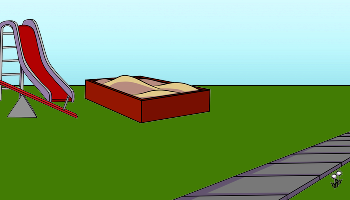

'Do you see people around?'

'Predicted answer: no'

In [42]:
import random

n = random.randint(1,1000)

# Image
path = join(training_dir,str(filenames_test[n])+'.png')
Image.open(path).resize((350,200), Image.NEAREST)

# Question
test_questions[n]

# Predicted answer
pr = weighted_argmax(predictions[n],n)
switched_labels_dict = {int(y):x for x,y in labels_dict.items()}
"Predicted answer: "+ switched_labels_dict[pr]

#### Actually generating dict for testing evaluation

In [33]:
i = 0
results = {}

for p in predictions:

    prediction = weighted_argmax(p,i)    
    results[question_ids[i]] = str(prediction)
    i += 1

#### CSV

In [31]:
create_csv(results)